<h1 style="color: #00BFFF;">00 |</h1>

In [6]:
# 📚 Basic libraries
import os # file managment
import matplotlib.pyplot as plt #  plots and visualizations
import numpy as np # numerical python, image array manipulation

# 🛠️ Tools
import warnings # who likes warnings?
import shutil # high-level file operations
import random # to generate random samples

# 🌐 Computer Vision
import cv2 # the most basic library to read images
from tensorflow.keras.preprocessing.image import ImageDataGenerator # real-time data augmentation
from tensorflow.keras.utils import img_to_array, array_to_img, load_img # saving augmented Data
from tensorflow.keras import layers, Model
from tensorflow import keras # deep learning and neural networks
from keras.models import load_model

In [5]:
# ⚙️ Settings
warnings.filterwarnings('ignore') # ignore warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # ignore 

In [ ]:
# 🎯 Specific Functions
def augment_images(data_dir, datagen, num_images=5):
    for filename in os.listdir(data_dir):
        if filename.endswith(".jpeg"):
            img_path = os.path.join(data_dir, filename)
            img_array = img_to_array(load_img(img_path))  # converting the image to numpy array
            img_array = img_array.reshape((1,) + img_array.shape)  # reshape the data

            # Generate new images
            for i, _ in enumerate(datagen.flow(img_array, batch_size=1, save_to_dir=data_dir, save_prefix='aug', save_format='jpeg')):
                if i >= num_images - 1:
                    break
                    
def unet_model(input_shape): # adapted from Keras
    inputs = layers.Input(shape=input_shape)

    # downsampling
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Dropout(0.2)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Dropout(0.2)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # bottleneck
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Dropout(0.2)(c3)
    
    # upsampling
    u1 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(0.2)(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.2)(c5)

    # output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    return Model(inputs, outputs)

<h1 style="color: #00BFFF;">01 | Data Extraction</h1>

This public hand dataset contains different folders (numeric) with two subfolders: no_bg and original.

The goal is to segment hands from unseen data with high precision.

In [4]:
data_path = os.path.join('C:\\Users\\apisi\\01. GitHub\\03. Projects\\07_hands_on_it', '01_data')
hands = os.path.join(data_path, 'public_hand_dataset')

<h1 style="color: #00BFFF;">02 | Data Cleaning</h1>

First, I need to move each .jpeg hand image from each original and no_bg folders.

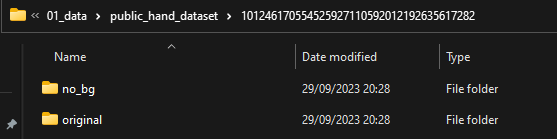

In [5]:
# new paths for thefolders
original = os.path.join(data_path, 'original')
no_bg = os.path.join(data_path, 'no_bg')

# creating folders
os.makedirs(original, exist_ok=True) # To not overwrite themm if they already exist
os.makedirs(no_bg, exist_ok=True)

Just run it once!

# now I will iterate for each folder inside hands directory
for folder in os.listdir(hands):
    unclean_hands = os.path.join(hands, folder)
    # paths for original and no_bg from the original dataset
    original_unclean = os.path.join(unclean_hands, 'original')
    no_bg_unclean = os.path.join(unclean_hands, 'no_bg')
    # copying (just in case to play it safe) images from each folder
    for image in os.listdir(original_unclean):
        new_image = f"hand_{folder[0:10]}.jpeg" # assigning some numbers from folder ID to my new images
        shutil.copyfile(os.path.join(original_unclean, image), os.path.join(original, new_image))
    for image in os.listdir(no_bg_unclean):
        new_image = f"hand_{folder[0:10]}.jpeg"
        shutil.copyfile(os.path.join(no_bg_unclean, image), os.path.join(no_bg, new_image))

<h1 style="color: #00BFFF;">03 | EDA</h1>

<h3 style="color: #008080;">Visualing Images</h3>

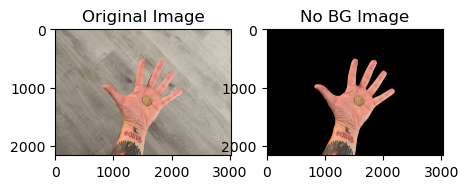

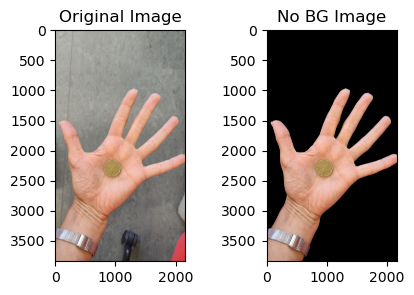

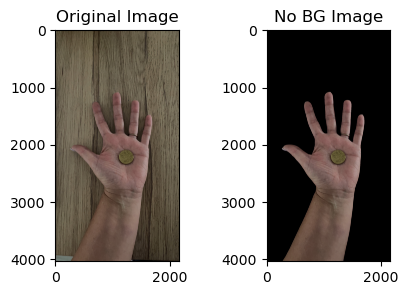

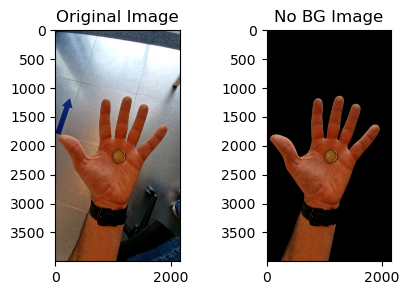

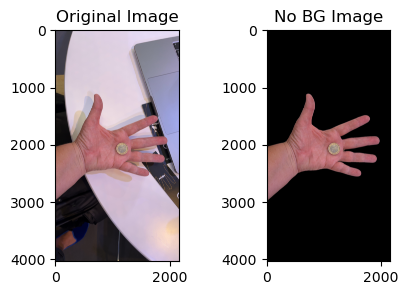

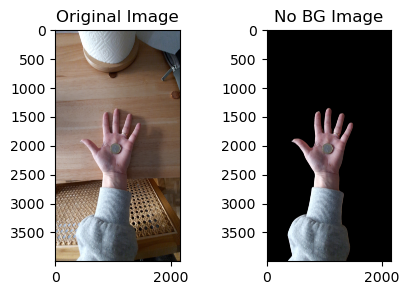

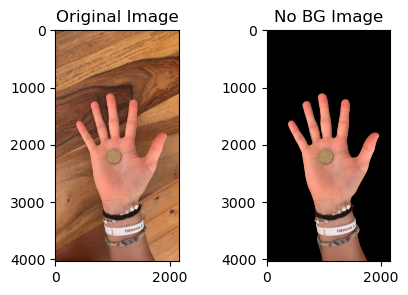

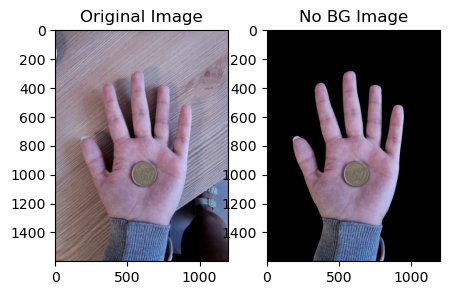

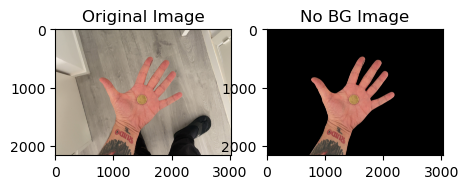

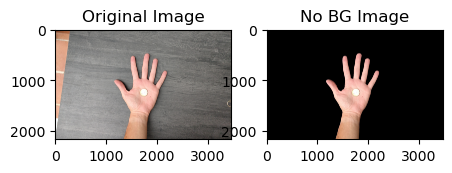

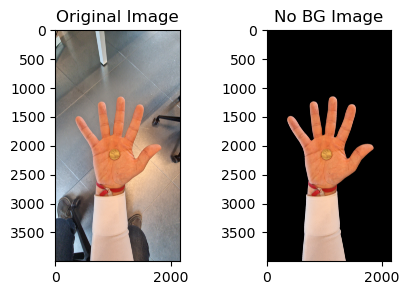

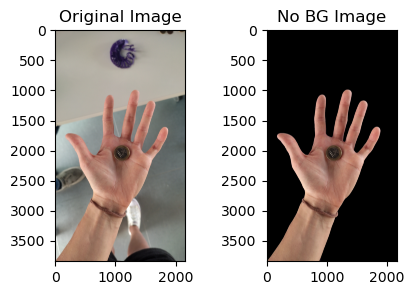

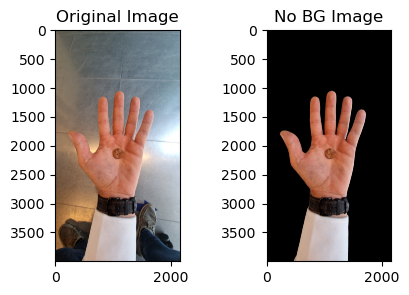

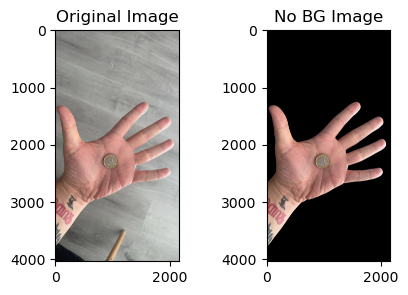

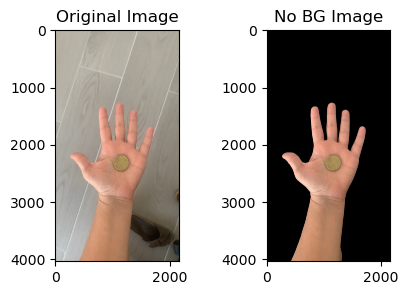

In [6]:
# a few random images to visualize
sample_images = random.sample(os.listdir(original), 15)

# plotting the images
for img_name in sample_images:
    original_img = cv2.imread(os.path.join(original, img_name))
    no_bg_img = cv2.imread(os.path.join(no_bg, img_name))
    
    plt.figure(figsize=(5, 3))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(no_bg_img, cv2.COLOR_BGR2RGB))
    plt.title('No BG Image')
    
    plt.show()

I can see many images with different sizes with background or not.

<h3 style="color: #008080;">Checking Image Sizes</h3>

In [7]:
image_sizes = {}
for img_name in os.listdir(original):
    img = cv2.imread(os.path.join(original, img_name))
    if img.shape[:2] not in image_sizes:
        image_sizes[img.shape[:2]] = 0
    image_sizes[img.shape[:2]] += 1
image_sizes

{(4032, 2160): 56,
 (4000, 2160): 40,
 (2048, 1536): 1,
 (3840, 2160): 11,
 (2160, 3468): 1,
 (4096, 2160): 7,
 (2160, 3024): 17,
 (2160, 3456): 7,
 (2160, 1440): 1,
 (2160, 3072): 1,
 (640, 480): 1,
 (2160, 3000): 4,
 (4080, 2160): 1,
 (1600, 1200): 1,
 (2304, 1728): 1}

The majority of the images are 4032x2160 or 4000x2160

For the model, I need them to be the same size, but I don't want to distort the original images so I'll firt calculate the aspect ratio

<h3 style="color: #008080;">Checking Aspect Ratios</h3>

In [8]:
aspect_ratios = {}

# Calculate aspect ratios for each image size
for dimensions, count in image_sizes.items():
    width, height = dimensions
    aspect_ratio = round(width / height, 2)
    aspect_ratios[dimensions, count] = aspect_ratio

aspect_ratios

{((4032, 2160), 56): 1.87,
 ((4000, 2160), 40): 1.85,
 ((2048, 1536), 1): 1.33,
 ((3840, 2160), 11): 1.78,
 ((2160, 3468), 1): 0.62,
 ((4096, 2160), 7): 1.9,
 ((2160, 3024), 17): 0.71,
 ((2160, 3456), 7): 0.62,
 ((2160, 1440), 1): 1.5,
 ((2160, 3072), 1): 0.7,
 ((640, 480), 1): 1.33,
 ((2160, 3000), 4): 0.72,
 ((4080, 2160), 1): 1.89,
 ((1600, 1200), 1): 1.33,
 ((2304, 1728), 1): 1.33}

<h2 style="color: #00BFFF;">Cleaning Data</h3>

I will keep, for the model only aspec ratios of 1.87 and 1.85 (majority class), to not have distorted images.

<h3 style="color: #008080;">Resizing Images</h3>

In [9]:
target_aspect_ratios = [1.87, 1.85]

# selecting images with the specific target ratios
selected_images = []

for image in os.listdir(original):
    img = cv2.imread(os.path.join(original, image))
    aspect_ratio = round(img.shape[0] / img.shape[1], 2)
    if aspect_ratio in target_aspect_ratios:
        selected_images.append(image)

print(f"Images safe to resize: {len(selected_images)}")

Images safe to resize: 96


In [10]:
# new folders for the images that I'll resize and use for the modeL:
original_clean_path = os.path.join(data_path, '00_original_clean')
no_bg_clean_path = os.path.join(data_path, '00_no_bg_clean')

# new directories
os.makedirs(original_clean_path, exist_ok=True)
os.makedirs(no_bg_clean_path, exist_ok=True)

Just run it once !

In [11]:
# now, I'll resize all images to adjust it for the model
size = (2160, 4000)

for image in os.listdir(original_clean_path):
    img_path = os.path.join(original_clean_path, image)
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, size)
    cv2.imwrite(img_path, img_resized)

for image in os.listdir(no_bg_clean_path):
    img_path = os.path.join(no_bg_clean_path, image)
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, size)
    cv2.imwrite(img_path, img_resized)

<h3 style="color: #008080;">Copying Selected Images</h3>

Just run it once !

# copying the selected images to the new directories
for image in selected_images:
    shutil.copyfile(os.path.join(original, image), os.path.join(original_clean_path, image))
    shutil.copyfile(os.path.join(no_bg, image), os.path.join(no_bg_clean_path, image))

After manually checking the folders, I see some no backgroudn images with background (not good for predicting the masks and segment).

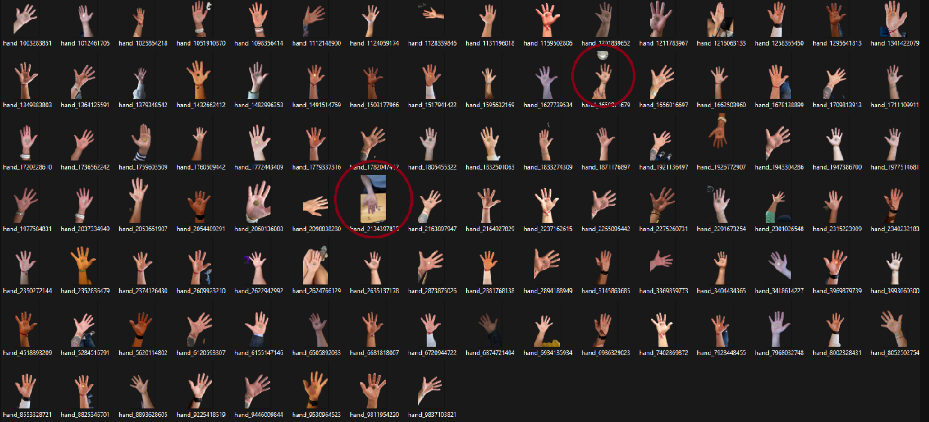

I will delete them manually, also their equivalent in the original dataset to avoid noise in my model

<h3 style="color: #008080;">Lenghts after cleaning</h3>

In [12]:
# obsessive checker is me
print(f'Lenght of no_bg_clean: {len(os.listdir(no_bg_clean_path))} and length of original_clean: {len(os.listdir(original_clean_path))}')

Lenght of no_bg_clean: 79 and length of original_clean: 79


<h3 style="color: #008080;">Preparing Training, Validation and Test folders</h3>

In [13]:
# original and no_bg directories for test
test_dir = os.path.join(data_path, "03_test")
os.makedirs(test_dir, exist_ok=True)
os.makedirs(os.path.join(test_dir, "original"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "mask"), exist_ok=True)

# original and no_bg directories for train and validation
train_dir = os.path.join(data_path, "01_train")
val_dir = os.path.join(data_path, "02_validation")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, "original"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "mask"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "original"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "mask"), exist_ok=True)

<h3 style="color: #008080;">Shuffling the Data</h3>

In [14]:
# Split data
all_images = os.listdir(original_clean_path)
np.random.shuffle(all_images)

<h3 style="color: #008080;">Training, Validation and Test split</h3>

For this model, we will split 65% to training Data, since it will be augmented, then 25% for validation (to have a bigger validation dataset) and the remaining 10% for testing.

In [15]:
num_train = int(0.65 * len(all_images))
num_val = int(0.25 * len(all_images))
train_images = all_images[:num_train]
val_images = all_images[num_train:num_train+num_val]
test_images = all_images[num_train+num_val:]

<h3 style="color: #008080;">Unique images for each</h3>

In [16]:
for img in train_images:
    shutil.copy(os.path.join(original_clean_path, img), os.path.join(train_dir, 'original', img))
    shutil.copy(os.path.join(no_bg_clean_path, img), os.path.join(train_dir, 'mask', img))

for img in val_images:
    shutil.copy(os.path.join(original_clean_path, img), os.path.join(val_dir, 'original', img))
    shutil.copy(os.path.join(no_bg_clean_path, img), os.path.join(val_dir, 'mask', img))

for img in test_images:
    shutil.copy(os.path.join(original_clean_path, img), os.path.join(test_dir, 'original', img))
    shutil.copy(os.path.join(no_bg_clean_path, img), os.path.join(test_dir, 'mask', img))

<h3 style="color: #008080;">Converting no background hand images to masks</h3>

Just run it once !

# for the training folder...
for image in os.listdir(os.path.join(train_dir, "mask")):
    img_path = os.path.join(train_dir, "mask", image)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
    mask_path = os.path.join(train_dir, "mask", image)
    cv2.imwrite(mask_path, mask)

# for the validation folder...
for image in os.listdir(os.path.join(val_dir, "mask")):
    img_path = os.path.join(val_dir, "mask", image)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
    mask_path = os.path.join(val_dir, "mask", image)
    cv2.imwrite(mask_path, mask)

# for the test folder...
for image in os.listdir(os.path.join(test_dir, "mask")):
    img_path = os.path.join(test_dir, "mask", image)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
    mask_path = os.path.join(test_dir, "mask", image)
    cv2.imwrite(mask_path, mask)

<h3 style="color: #008080;">Debugging ImageDataGenerator</h3>

ImageDataGenerator wasn't detecting images. They need to be in subfolders.

In [18]:
train_original_dir = os.path.join(train_dir, "original")
train_mask_dir = os.path.join(train_dir, "mask")

val_original_dir = os.path.join(val_dir, "original")
val_mask_dir = os.path.join(val_dir, "mask")

test_original_dir = os.path.join(test_dir, "original")
test_mask_dir = os.path.join(test_dir, "mask")

Just run it once !

# subdirectories in the training set
train_sub_original = os.path.join(train_dir, "original", "sub_original")
train_sub_mask = os.path.join(train_dir, "mask", "sub_mask")

# subdirectories for the training set
os.makedirs(train_sub_original, exist_ok=True)
os.makedirs(train_sub_mask, exist_ok=True)

# images to subdirectories for the training set
for img in os.listdir(os.path.join(train_dir, "original")):
    if not os.path.isdir(os.path.join(train_dir, "original", img)):
        shutil.move(os.path.join(train_dir, "original", img), train_sub_original)
        
for img in os.listdir(os.path.join(train_dir, "mask")):
    if not os.path.isdir(os.path.join(train_dir, "mask", img)):
        shutil.move(os.path.join(train_dir, "mask", img), train_sub_mask)

# new subdirectories in the validation set
val_sub_original = os.path.join(val_dir, "original", "sub_original")
val_sub_mask = os.path.join(val_dir, "mask", "sub_mask")

# subdirectories for the validation set
os.makedirs(val_sub_original, exist_ok=True)
os.makedirs(val_sub_mask, exist_ok=True)

# images to the subdirectories for the validation set
for img in os.listdir(os.path.join(val_dir, "original")):
    if not os.path.isdir(os.path.join(val_dir, "original", img)):
        shutil.move(os.path.join(val_dir, "original", img), val_sub_original)
        
for img in os.listdir(os.path.join(val_dir, "mask")):
    if not os.path.isdir(os.path.join(val_dir, "mask", img)):
        shutil.move(os.path.join(val_dir, "mask", img), val_sub_mask)
        
# subdirectories in the test set
test_sub_original = os.path.join(test_dir, "original", "sub_original")
test_sub_mask = os.path.join(test_dir, "mask", "sub_mask")

# subdirectories for the test set
os.makedirs(test_sub_original, exist_ok=True)
os.makedirs(test_sub_mask, exist_ok=True)

# images to the subdirectories for the test set
for img in os.listdir(os.path.join(test_dir, "original")):
    if not os.path.isdir(os.path.join(test_dir, "original", img)):
        shutil.move(os.path.join(test_dir, "original", img), test_sub_original)
        
for img in os.listdir(os.path.join(test_dir, "mask")):
    if not os.path.isdir(os.path.join(test_dir, "mask", img)):
        shutil.move(os.path.join(test_dir, "mask", img), test_sub_mask)

<h1 style="color: #00BFFF;">04 | Data Pre-Processing</h1>

<h3 style="color: #008080;">Noise Reduction</h3>

Bilateral Filtering:

In [76]:
def apply_denoising(img):
    # Bilateral Filtering
    bilateral = cv2.bilateralFilter(img, 9, 75, 75)
    return bilateral

<h3 style="color: #008080;">Histogram Equalization</h3>

CLAHE:

In [77]:
def enhance_contrast(img):
    # if the image is grayscale or not. If not, convert it.
    if len(img.shape) == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    gray = np.uint8(gray)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) # applying CLAHE
    clahe_img = clahe.apply(gray)
    
    return clahe_img

<h3 style="color: #008080;">Edge Detection</h3>

Canny Edges:

In [78]:
def canny_edge_detector(img):
    # if the image is already grayscale. If not, convert it.
    if len(img.shape) == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    edges_canny = cv2.Canny(gray, 50, 150) # canny edges
    
    return edges_canny

<h3 style="color: #008080;">Morphological Operations:</h3>

Dilatation:

In [79]:
def apply_dilation(img, kernel_size=5, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilation = cv2.dilate(img, kernel, iterations=iterations)
    return dilation

<h3 style="color: #008080;">All pre-processing methods:</h3>

In [96]:
def custom_preprocessing(img):
    denoised_img = apply_denoising(img)
    clahe_img = enhance_contrast(denoised_img)
    edges = canny_edge_detector(clahe_img)
    dilation_img = apply_dilation(edges)
    
    dilation_img_3ch = np.stack([dilation_img]*3, axis=-1) # single channel to a 3 channel image
    
    return dilation_img_3ch.astype(np.float32) # converting it as a float for rescaling

<h3 style="color: #008080;">Pixel Normalization + Pre-Processing</h3>

In [97]:
train_image_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=custom_preprocessing)
train_mask_datagen = ImageDataGenerator(rescale=1./255) # masks without pre-processing techniques

val_image_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=custom_preprocessing)
val_mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=custom_preprocessing)
test_mask_datagen = ImageDataGenerator(rescale=1./255)

<h2 style="color: #00BFFF;">Data Augmentation</h3>

In [98]:
# Data Augmentation parameters to the training folder
datagen = ImageDataGenerator(
    brightness_range=[0.5, 1.5],
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1
)

Just run it once !

augment_images(os.path.join(train_sub_original), datagen, num_images=5)
augment_images(os.path.join(train_sub_mask), datagen, num_images=5)

<h1 style="color: #00BFFF;">05 | Modeling</h1>

<h3 style="color: #00BFFF;">Improving is an iterative process...</h3>

<h3 style="color: #008080;">Fine-Tunning the Model</h3>

In [99]:
# Parameters that we can fine-tune later on
img_height = 480
img_width = 272
image_size = (img_height, img_width)
batch_size = 8

<h3 style="color: #008080;">Train and Validation Data</h3>

In [100]:
train_image_gen = train_image_datagen.flow_from_directory(
    train_original_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

train_mask_gen = train_mask_datagen.flow_from_directory(
    train_mask_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False
)

train_ds = zip(train_image_gen, train_mask_gen)

Found 303 images belonging to 1 classes.
Found 303 images belonging to 1 classes.


In [101]:
val_image_gen = val_image_datagen.flow_from_directory(
    val_original_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

val_mask_gen = val_mask_datagen.flow_from_directory(
    val_mask_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False
)

val_ds = zip(val_image_gen, val_mask_gen)

Found 19 images belonging to 1 classes.
Found 19 images belonging to 1 classes.


<h3 style="color: #008080;">Compiling the Model</h3>

In [102]:
model = unet_model(input_shape=(img_height, img_width, 3))

model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

steps_per_epoch = len(train_image_gen)
validation_steps = len(val_image_gen)

checkpoints = os.path.join(data_path, "04_epochs", "save_at_{epoch}.keras")

In [103]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # my patience for this
    verbose=1,
    restore_best_weights=True 
)

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoints),
    early_stopping
]

hist = model.fit(
    train_ds, 
    epochs=epochs, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30
38/38 [==============================] - 263s 7s/step - loss: 0.7619 - accuracy: 0.5553 - val_loss: 0.5933 - val_accuracy: 0.7298
Epoch 2/30
38/38 [==============================] - 280s 7s/step - loss: 0.6705 - accuracy: 0.6343 - val_loss: 0.5782 - val_accuracy: 0.7298
Epoch 3/30
 7/38 [====>.........................] - ETA: 3:54 - loss: 0.6491 - accuracy: 0.6609

<h1 style="color: #00BFFF;">06 | Evaluating the Model</h1>

In [21]:
#  path to best epoch
checkpoint_path = os.path.join(data_path, "04_epochs", "save_at_transfer_30.keras")

# load the model
loaded_model = load_model(checkpoint_path)

In [ ]:
test_image_gen = test_image_datagen.flow_from_directory(
    test_original_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

test_mask_gen = test_mask_datagen.flow_from_directory(
    test_mask_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False
)

In [ ]:
test_ds = zip(test_image_gen, test_mask_gen)

# Evaluate the model
loss, accuracy = loaded_model.evaluate(test_ds, steps=len(test_image_gen))

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
images, masks = next(test_ds)

# predict masks using the model
predicted_masks = loaded_model.predict(images)

# plotting original, true masks, predicted masks, and segmented images
for i in range(min(5, batch_size)):
    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, 4, 1)
    image_to_display = (images[i] * 255).astype(np.uint8)
    plt.imshow(image_to_display)
    plt.title('Original Image')

    # Display true mask
    plt.subplot(1, 4, 2)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title('True Mask')

    # Display predicted mask
    plt.subplot(1, 4, 3)
    plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    
    # Display segmented image
    plt.subplot(1, 4, 4)
    segmented_image = (images[i] * predicted_masks[i].squeeze()[:, :, np.newaxis]).astype(np.uint8)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')
    
    plt.tight_layout()
    plt.show()